In [16]:
import laspy
import open3d as o3d
import numpy as np
import math

In [17]:
las = laspy.read("../frame_with_depth/lidar_sensor_00002.las")

points = np.vstack((las.x, las.y, las.z)).T

pcd = o3d.geometry.PointCloud()

pcd.points = o3d.utility.Vector3dVector(points)

In [18]:
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=1.0, origin=[0, 0, 0])

o3d.visualization.draw_geometries([pcd, mesh_frame])

(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

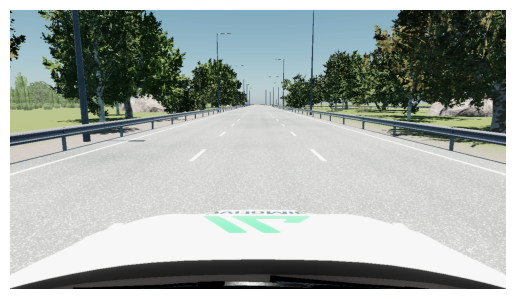

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
im = Image.open("../frame_with_depth/pinhole_00002.tga")
img = np.array(im)
h, w, _ = img.shape
plt.imshow(img)
plt.axis('off')



In [20]:
# maybe we need to transform the coordinates of the pointcloud to ego (body) space.
points

array([[ 1.18685,  0.     , -0.83105],
       [ 1.54045,  0.     , -1.0293 ],
       [ 1.67895,  0.     , -1.0696 ],
       ...,
       [10.0546 , -0.03505, -2.     ],
       [11.3425 , -0.03955, -2.     ],
       [15.1914 , -0.053  , -2.     ]], shape=(55709, 3))

point cloud is just a list of 3d coordinates of the points


In [25]:
# we need the transformation called sensor_pom
# from ..src.calculation_for_transformsfile import calculate_pom_deg

def euler_zyx_to_matrix(yaw_rad, pitch_rad, roll_rad):
    """
    Converts Euler ZYX (Yaw, Pitch, Roll) angles to a 4x4 rotation matrix.
    Note: See the aiSim documentation Coordinate transforms page. This is Python version of the Cpp code in the documentation
    """
    sin_z, cos_z = math.sin(yaw_rad), math.cos(yaw_rad)
    sin_y, cos_y = math.sin(pitch_rad), math.cos(pitch_rad)
    sin_x, cos_x = math.sin(roll_rad), math.cos(roll_rad)

    # Rz (Rotation around Z-axis)
    # GLM matrix definition is column-major, we transpose to row-major for numpy storage.
    # The GLM code shows the *columns* of the matrix. We use row-major for numpy:
    # Rz = [[cos_z, sin_z, 0], [-sin_z, cos_z, 0], [0, 0, 1]] (Transposed from GLM column vectors)
    Rz = np.array([
        [cos_z, -sin_z, 0.0],
        [sin_z, cos_z, 0.0],
        [0.0, 0.0, 1.0]
    ])
    
    # Ry (Rotation around Y-axis)
    # Ry = [[cos_y, 0, sin_y], [0, 1, 0], [-sin_y, 0, cos_y]] (Transposed from GLM column vectors)
    Ry = np.array([
        [cos_y, 0.0, sin_y],
        [0.0, 1.0, 0.0],
        [-sin_y, 0.0, cos_y]
    ])

    # Rx (Rotation around X-axis)
    # Rx = [[1, 0, 0], [0, cos_x, -sin_x], [0, sin_x, cos_x]] (Transposed from GLM column vectors)
    Rx = np.array([
        [1.0, 0.0, 0.0],
        [0.0, cos_x, -sin_x],
        [0.0, sin_x, cos_x]
    ])

    # The final rotation matrix R is calculated as Rz * Ry * Rx
    # R = Rz @ Ry @ Rx
    R = Rz @ Ry @ Rx
    
    # Create the 4x4 homogeneous matrix with a 0 translation vector initially
    M = np.identity(4)
    M[:3, :3] = R
    
    return M

def calculate_pom_deg(position, yaw_deg, pitch_deg, roll_deg):
    """
    Calculates the Position and Orientation Matrix (POM) in degrees.
    :param position: [x, y, z] vector of the sensor's position (e.g., [1.8, 0, 1.5]).
    :param yaw_deg: Yaw angle in degrees.
    :param pitch_deg: Pitch angle in degrees.
    :param roll_deg: Roll angle in degrees.
    :return: 4x4 homogeneous transformation matrix (row-major).
    """
    yaw_rad, pitch_rad, roll_rad = (
        math.radians(yaw_deg), 
        math.radians(pitch_deg), 
        math.radians(roll_deg)
    )
    
    # Get the 4x4 rotation matrix
    pom = euler_zyx_to_matrix(yaw_rad, pitch_rad, roll_rad)
    
    pom[:3, 3] = position # last column
    
    return pom

In [22]:
first_point = points[1]
print(first_point)
# What is the color of this point?

[ 1.54045  0.      -1.0293 ]


In [23]:
# 1. Where is this point relative to camera?
# position of the pinhole is in [1.8, 0, 1.5]
# rotation parameters are there also
#

# 2. Where is this point projected onto the image?
#
# 3. Pick the color



In [26]:
camera_position = [1.8, 0, 1.5]
point_pos_from_camera = first_point - camera_position
print(point_pos_from_camera)

# Where is the camera is looking?
yaw, pitch, roll = 0, 9, 0
pom = calculate_pom_deg(camera_position, yaw, pitch, roll)
print(pom)

[-0.25955  0.      -2.5293 ]
[[ 0.98768834  0.          0.15643447  1.8       ]
 [ 0.          1.          0.          0.        ]
 [-0.15643447  0.          0.98768834  1.5       ]
 [ 0.          0.          0.          1.        ]]


In [38]:
# Lidar sensor parameters
lidar_pos =  np.array([1, 0,2])

lidar_rot =  {
                    "pitch": 0,
                    "roll": 0,
                    "yaw": 0
                }


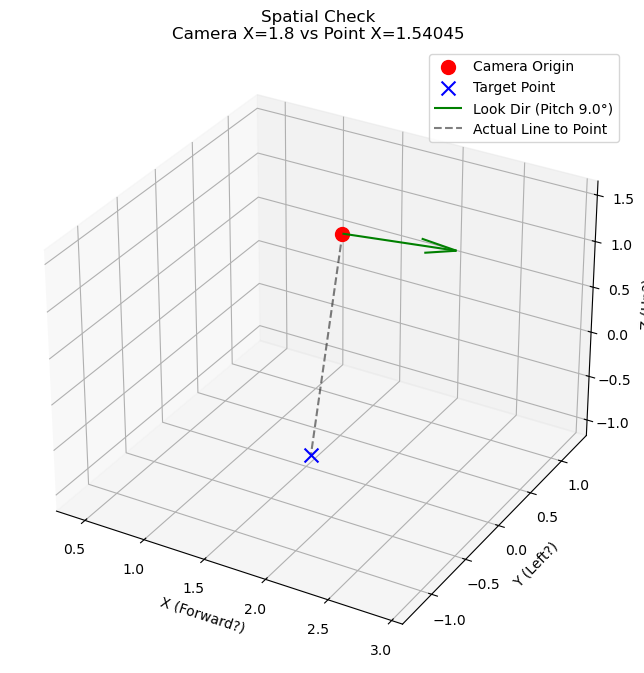

Distance to point: 0.91 meters
Vector to point:   [ 0.74045  0.      -0.5293 ]


In [40]:
import matplotlib.pyplot as plt
import numpy as np
N = 1

# --- 1. SETUP DATA ---
# Your exact coordinates
camera_pos = np.array([1.8, 0.0, 1.5])       # Position (x, y, z)
target_point = np.array(points[N]) # The LiDAR point

# Orientation (Degrees)
yaw_deg = 0.0   # Facing standard Forward (+X)
pitch_deg = 9.0 # Tilted up 9 degrees? (Or down? see note below)

# --- 2. MATH: CALCULATE VECTORS ---
# Vector from Camera -> Point
relative_vector = (lidar_pos + target_point) - camera_pos
distance = np.linalg.norm(relative_vector)

# Camera Look Direction (Unit Vector)
# Assumption: 0=Forward(+X), 90=Left(+Y)
yaw_rad = np.radians(yaw_deg)
pitch_rad = np.radians(pitch_deg)

look_dir = np.array([
    np.cos(yaw_rad) * np.cos(pitch_rad),
    np.sin(yaw_rad) * np.cos(pitch_rad),
    np.sin(pitch_rad)
])

# Scale arrow for visibility (make it as long as the distance to point)
arrow_vec = look_dir * distance

# --- 3. PLOT ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot Camera (Red Dot)
ax.scatter(*camera_pos, color='red', s=100, label='Camera Origin')

# Plot Target Point (Blue X)
ax.scatter(*target_point, color='blue', marker='x', s=100, label='Target Point')

# Plot View Direction (Green Arrow)
ax.quiver(
    camera_pos[0], camera_pos[1], camera_pos[2], # Start
    arrow_vec[0], arrow_vec[1], arrow_vec[2],    # Direction
    color='green', label=f'Look Dir (Pitch {pitch_deg}°)'
)

# Plot "Error Line" (Dotted Black)
# Connects Camera to Point so you can see the difference
ax.plot(
    [camera_pos[0], target_point[0]],
    [camera_pos[1], target_point[1]],
    [camera_pos[2], target_point[2]],
    'k--', alpha=0.5, label='Actual Line to Point'
)

# --- 4. FORMATTING ---
ax.set_xlabel('X (Forward?)')
ax.set_ylabel('Y (Left?)')
ax.set_zlabel('Z (Up?)')
ax.set_title(f'Spatial Check\nCamera X={camera_pos[0]} vs Point X={target_point[0]}')
ax.legend()

# Force equal aspect ratio to prevent distortion
# (Visualizing distances correctly is impossible without this)
all_points = np.vstack([camera_pos, target_point])
max_range = (all_points.max() - all_points.min()) / 2.0
mid_x = (camera_pos[0] + target_point[0]) * 0.5
mid_y = (camera_pos[1] + target_point[1]) * 0.5
mid_z = (camera_pos[2] + target_point[2]) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()

# --- DIAGNOSTIC PRINT ---
print(f"Distance to point: {distance:.2f} meters")
print(f"Vector to point:   {relative_vector}")
if relative_vector[0] < 0:
    print("⚠ WARNING: Point is BEHIND the camera (X is negative relative to cam)")